# Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll then create our tokenizers as before.

In [3]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [6]:
SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

We then load the Multi30k dataset and build the vocabulary.

In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.fr', '.en'), 
                                                    fields = (SRC, TRG),
                                                   root = '.')

In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Finally, we define the device and the data iterator.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

ConvSeq2Seq과 유사하게, Transformer의 encoder는 전체 source 문장 $X = (x_1, ... ,x_n)$을 하나의 컨텍스트 벡터 $z$로 바꾸려고 하지 않았습니다. 대신에 컨텍스 벡터 시퀀스 $Z = (z_1, ... , z_n)$를 만들었습니다. 그래서, 만약 우리의 input 길이가 5개 길이의 토큰이라면, 우리는 컨텍스트 벡터$Z = (z_1, z_2, z_3, z_4, z_5)$ 를 가질 것입니다. 우리는 이를 히든벡터로 안부르고 컨텍스트 벡터라고 부를까요? RNN의 $t$시점의 히든스테이트는 오직 $x_t$와 이 토큰 이전의 토큰들만 봤습니다. 하지만, 각 컨텍스트 벡터는 인풋 시퀀스 내의 모든 포지션의 모든 단어를 봤습니다. 

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. 이는 인풋이 단어 자체가 아니라 단어의 위치인 일반적인 임베딩 레이어라는 것이 다릅니다. 즉 `<sos>` 토큰 대신에 0이 들어가게 됩니다. position embedding의 "vocabulary" 크기는 100인데, 이는 우리가 최대 100 token의 길이까지만 받아들일 수 있다는 것을 의미합니다. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

이후, 토큰 임베딩과, 포지셔널 임베딩은 element-wise하게 합이 외어 토큰에 대한 정보와 시퀀스 내의 포지션에 대한 정보를 포함하게 됩니다. 그들이 더해지기 전에, 토큰 임베딩은 scaling factor인  $\sqrt{d_{model}}$을 곱해지게 됩니다. 이 때 $d_{model}$ 는 hidden dimension size인 `hid_dim`입니다. 이는 추정건데 임베딩 내에 있는 분산을 줄이고 모델이 scaling factor 없이 학습을 신뢰도 있게 하기 어렵게 만듭니다. Dropout은 합해진 embeddings에 적용됩니다.

이 합해진 embeddings은 $N$개의 *encoder layers*를 지나서 $Z$를 얻고, 나중에 decoder에서 사용되게 됩니다.

source mask `src_mask`는 소스 문자오가 같은 shape를 가지고 있고 source 문장 내에서 토큰이 `<pad>` 토큰일 때 1, 아닐 때 0을 가지는 값입니다. 이는 multi-head attention에서 source 문장의 attention을 계산하고 적용할 때 mask를 하기 위해 사용되는데, 모델이 `<pad>` tokens에 의미 없이 학습되지 않게 합니다.

In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, # vocabulary 개수
                 hid_dim,   # token의 임베딩 차원
                 n_layers,  # self-attention + FCN 레이어를 몇 층 쌓을건지
                 n_heads,   # 몇 개의 multi-head self-attention
                 pf_dim,    # FCN의 dimension
                 dropout,  
                 device,
                 max_length = 100): 
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #     (src_len)              (1, src_len)  (batch_size, src_len)  
        
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

##  pos 

In [11]:
pos = torch.arange(0, 10).unsqueeze(0).repeat(3, 1)
pos

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [12]:
pos_embedding = nn.Embedding(10, 100)

In [13]:
pos_embedding(pos).shape

torch.Size([3, 10, 100])

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. 우리는 처음으로 source 문장과 mask를 *multi-head attention layer*에 통과시키고, 이에 dropout을 적용하고, residual connection을 적용하고 그리고 이를 [Layer Normalization](https://arxiv.org/abs/1607.06450) layer에 통과시킵니다. 우리는 그리고 이를  *position-wise feedforward* layer 에 다시 통과시키고, dropout을 적용하고, residual connection과 layer normalization를 적용시킨뒤 output을 구해서 다음 레이어에 넣어줍니다. 레이어 간 파라미터는 공유되지 않습니다. 

The mutli head attention layer는 source sentence를 encoder layer에서 attend시키려고 사용됩니다. 즉 다른 시퀀스가 아닌 그 문장 자체의 어텐션을 계산하고 적용하고, 이때문에 *self attention*이라고 불립니다.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### nn.LayerNorm 
은닉 유닉 값의 평균값과 표준분포가 모델 안에서 학습되는 파라미터로 정규화되도록 하는 레이어
- normalized_shape (int or list or torch.Size) – input shape from an expected input of size

If a single integer is used, it is treated as a singleton list, and this module will normalize over the last dimension which is expected to be of that specific size.

- eps – a value added to the denominator for numerical stability. Default: 1e-5

- elementwise_affine – a boolean value that when set to True, this module has learnable per-element affine parameters initialized to ones (for weights) and zeros (for biases). Default: True.

In [15]:
>>> input = torch.randn(3, 4)
>>> # With Learnable Parameters
>>> m = nn.LayerNorm(input.size()[1:])

In [16]:
input.shape, m(input).shape

(torch.Size([3, 4]), torch.Size([3, 4]))

In [17]:
m(input).mean(dim = 1)

tensor([-1.4901e-07, -3.7253e-09, -2.9802e-08], grad_fn=<MeanBackward1>)

In [18]:
m(input).std(dim = 1)

tensor([1.1547, 1.1547, 1.1547], grad_fn=<StdBackward1>)

In [19]:
list(m.named_parameters()) 

[('weight',
  Parameter containing:
  tensor([1., 1., 1., 1.], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0., 0., 0., 0.], requires_grad=True))]

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

그러나 scaled dot-product attention은 단순히 queries, keys, value에만 적용되는 것이 아닙니다. 쿼리, 키, 벨류에 대한 단순한 어텐션 적용을 하는 것 대신에, key와 value는 `hid_dim`을 가지고 있어서 $h$ *heads*로 나눠져서 모든 head들이 병렬로 scaled dot-product로 계산되게 됩니다. 이는 어텐션 적용에 하나의 컨셉으로 집중하는 것 대신에, $h$에 집중하는 것으로 볼 수 있습니다. 우리는 그 이후, `hid_dim`으로 다시 재결합 시켜서, 각각의 `hid_dim`은 $h$개의 다른 컨셉에 잠재적으로 집중할 수 있도록 합니다.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$는 multi-head 어텐션 레이어의 마지막인 linear layer dls `fc`에 적용됩니다. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

모듈에 대해서 보자면, 

1) 첫번째로 우리는 lineqr layer `fc_q`, `fc_k` and `fc_v`와 함께 $QW^Q$, $KW^K$ and $VW^V$를 계산하고, 이는 
`Q`, `K` and `V`를 줍니다. 

2) 다음으로 우리는 `hid_dim`차원의 query, key, value를 `.view`를 통해 `n_heads`로 나누고 정확하게 permute를 시켜 같이 곱셈 연산을 할 수 있게합니다. 우리는 그 이후에 `Q`와 `K`를 곱한 뒤, `head_dim(= hid_dim // n_heads)`의 제곱근으로 나누어서 `energy` (the un-normalized attention)를 계산합니다. 

3) 이후로 우리는 시퀀스 내에서 우리가 집중해지 말아야 할 원소에 대해서 energy를 마스크를 합니다.

4) 그리고 softmax와 dropout을 적용시킵니다.

5) value head `V`에 어텐션을 적용시킨 다음 `n_heads`만큼 concat 시킵니다. 

6) 마지막으로 우리는 이를 $W^O$와 곱해줍니다(`fc_o`). 

우리의 implementation에서 key, value의 길이가 항상 같은 것을 알아두세요, 그러므로 matrix(`V`)가 softmax의 아웃풋(`attention`)과 곱해질때, 우리는 언제나 matrix 곱셈에서 맞는 dimension size를 가질 것입니다. 이러한 연산은 `torch.matmul`을 통해 수행될건데, 이 연산은  두 tensor가 2차원 초과일 때, 각 텐서의 뒤의 두 차원에 대한 batched matrix multiplication을 합니다. 이는 **[query len, key len] x [value len, head dim]** 과 같은 연산을 할걸고, batch size와 head에 대한 batched matrix multiplication은 **[batch size, n heads, query len, head dim]** 결과를 낼 것입니다.

처음에 이상해 보일 한 가지는 dropout이 바로 어텐션에 적용됐다는 점입니다. **This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout.** This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

# `matmul`
https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul

broadcasting된다는 것이 bmm과의 차이

In [20]:
>>> # batched matrix x broadcasted matrix
>>> tensor1 = torch.randn(10, 3, 4)
>>> tensor2 = torch.randn(4, 5)
>>> torch.matmul(tensor1, tensor2).size()

torch.Size([10, 3, 5])

# 깨달음 1
난 당연히 n_heads마다 head_dim차원의 Q, K, V를 만들거라고 생각했는데, hid_dim 차원의 Q, K, V로 만들어 놓고 이를 n_heads만큼으로 자르는게 특이함. 어차피 각각의 head 별로 다르게 학습되어야 하니까 상관은 없음.. 이것도 저번 달의 concat trick 같은 거라고 볼 수도 있겠다

# 깨달음 2

#Q = [batch size, query len, hid dim]

Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

여기에서 Q.view(batch_size, self.n_heads, -1, self.head_dim)로 한번에 하면 어그러지겠구나..이런거 주의하자

In [21]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        # k.permute(0, 1, 3, 2) = [batch size, n heads, head dim, key len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        # n_heads * head_dim을 hid dim으로 합치는 부분
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

# `masked_fill`

In [22]:
x = torch.arange(10)
mask = x < 5 
x.masked_fill(mask, 3)

tensor([3, 3, 3, 3, 3, 5, 6, 7, 8, 9])

# 깨달음 3
FCN이 다시 hid dim 크기로 다시 줄이는 줄 몰랐음. 그런데 layer위로 높이거나 그러려면 당연히 그래야겠구나.
shape이 그대로여서 position-wise라는 이름이 만들어졌나?

### Position-wise Feedforward Layer

다른 encoder layer내의 main block은 *position-wise feedforward layer*입니다. 이는 비교적 다른 multi-head attention layer에 비하면 단순합니다. 이 input은 `hid_dim`에서 `pf_dim`으로 transform 하고, `pf_dim` 은 대개 `hid_dim`보다 훨씬 큽니다. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

왜 사용될까요? 불행히도 논문에서 설명된 적이 없습니다.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

decoder의 목표는 source sentence의 인코드된 표현 $Z$을 가지고, 타겟 문장 에 있는 predicted token $\hat{Y}$으로 바꾸는 것입니다. 그리고 나서 우리는 $\hat{Y}$와 타겟 문장에 있는 실제 토큰  $Y$와 비교를 하고 loss를 계산하고 역전파를 하고 파라미터를 튜닝합니다.

![](assets/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. 타겟 문장에 대한 *masked multi-head attention layer*과 decoder 표현을 query로 하고, 인코더 표현을 key와 value로 하는 multi-head attention layer입니다. 

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. 둘다 $N$으로 표현되었지만, encoder에 있는 레이어의 개수는 디코더의 레이어의 개수와 같을 필요가 없음을 알아두세요. 

$N^{th}$개의 레이어 후의 decoder 표현은 그 이후에 linear layer인 `fc_out`을 통과시킵니다. 
PyTorch에서 softmax연산이 loss function에 포함되어 있기 때문에, 우리는 명시적으로 softmax layer를 쓸 필요가 없습니다.

source mask에서 뿐 아니라, 우리는 인코더에서의 `<pad>` 토큰에 대해서도 attend를 되는 것을 막기 위해 target mask를 사용합니다. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [24]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

처음으로는 encoder에서처럼 self-attention을 실행합니다, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization.  이러한 `self_attention` 레이어는 target sentence mask인 `trg_mask`를 사용하고, 이는 decoder가 현재 위치 이후에 있는 토큰에 attend하는 "cheating"을 막아줍니다.

두번째는 우리가 실제로 encoded source sentence인 `enc_src`를 decoder에 주어야합니다. 이 multi-head attention 레이어에서 query는  decoder 표현이고, key와 value는 인코더 표현입니다. 여기서, soruce mask인 `src_mask`는 multi-head attention layer가 `<pad>` 토큰에 attend 하는 것을 막아줍니다.

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

드디어 우리는 인코더와 디코더를 함께 넣는 부분과 mask를 만드는 부분까지 포함하는 `Seq2Seq` 차례입니다.

source mask는 source sequence가 `<pad>` 토큰과 같은지를 체크합니다. It is 1 where the token is not a `<pad>` token and 0 when it is. 그리고 나서 unsqueeze를 함으로서 shape이 **_[batch size, n heads, seq len, seq len]_**인 `energy` 함수에서 mask에 올바르게 broadcasting됩니다.

target mask는 살짝 더 복잡합니다. 우선, source mask를 만든 것 처럼 `pad` token을 위한 마스크를 만듭니다. 그리고 나서 `torch.tril`를 사용하여 `trg_sub_mask`인 "다음" mask를 만듭니다. 이것은 diagnoal 위는 0이고 아래는 input tensor로 설정되는 diagnoal matrix를 만들 것입니다. 이 경우에 input tensor는 1로 채워지게 됩니다. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

# `tril`

In [26]:
torch.tril(torch.Tensor(3, 4))

tensor([[2.5226e-18, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.6409e-06, 4.1881e-11, 0.0000e+00, 0.0000e+00],
        [6.7333e+22, 1.7591e+22, 1.7184e+25, 0.0000e+00]])

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,684,037 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [31]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [32]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [33]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

`<eos>` 토큰을 예측하기를 바라나, input으로 넣어주길 원하지 않으므로 시퀀스 끝 부분을 slice해줍시다.
그러므로, 

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. loss 를 계산할 때, 앞의 `<sos>` 토큰을 slice 해버리고 `<eos>`토큰은 남기고 loss 를 구합시다.

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [35]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg
        

        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [36]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [38]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 16s
	Train Loss: 4.173 | Train PPL:  64.887
	 Val. Loss: 2.882 |  Val. PPL:  17.853
Epoch: 02 | Time: 0m 16s
	Train Loss: 2.592 | Train PPL:  13.354
	 Val. Loss: 2.045 |  Val. PPL:   7.727
Epoch: 03 | Time: 0m 16s
	Train Loss: 1.958 | Train PPL:   7.084
	 Val. Loss: 1.696 |  Val. PPL:   5.454
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.592 | Train PPL:   4.916
	 Val. Loss: 1.509 |  Val. PPL:   4.523
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.348 | Train PPL:   3.848
	 Val. Loss: 1.400 |  Val. PPL:   4.054
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.168 | Train PPL:   3.216
	 Val. Loss: 1.342 |  Val. PPL:   3.828
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.030 | Train PPL:   2.800
	 Val. Loss: 1.305 |  Val. PPL:   3.686
Epoch: 08 | Time: 0m 16s
	Train Loss: 0.918 | Train PPL:   2.505
	 Val. Loss: 1.296 |  Val. PPL:   3.656
Epoch: 09 | Time: 0m 16s
	Train Loss: 0.824 | Train PPL:   2.279
	 Val. Loss: 1.296 |  Val. PPL:   3.653
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.748 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [39]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.240 | Test PPL:   3.455 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [40]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [41]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [42]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [43]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'bag', 'walks', 'by', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


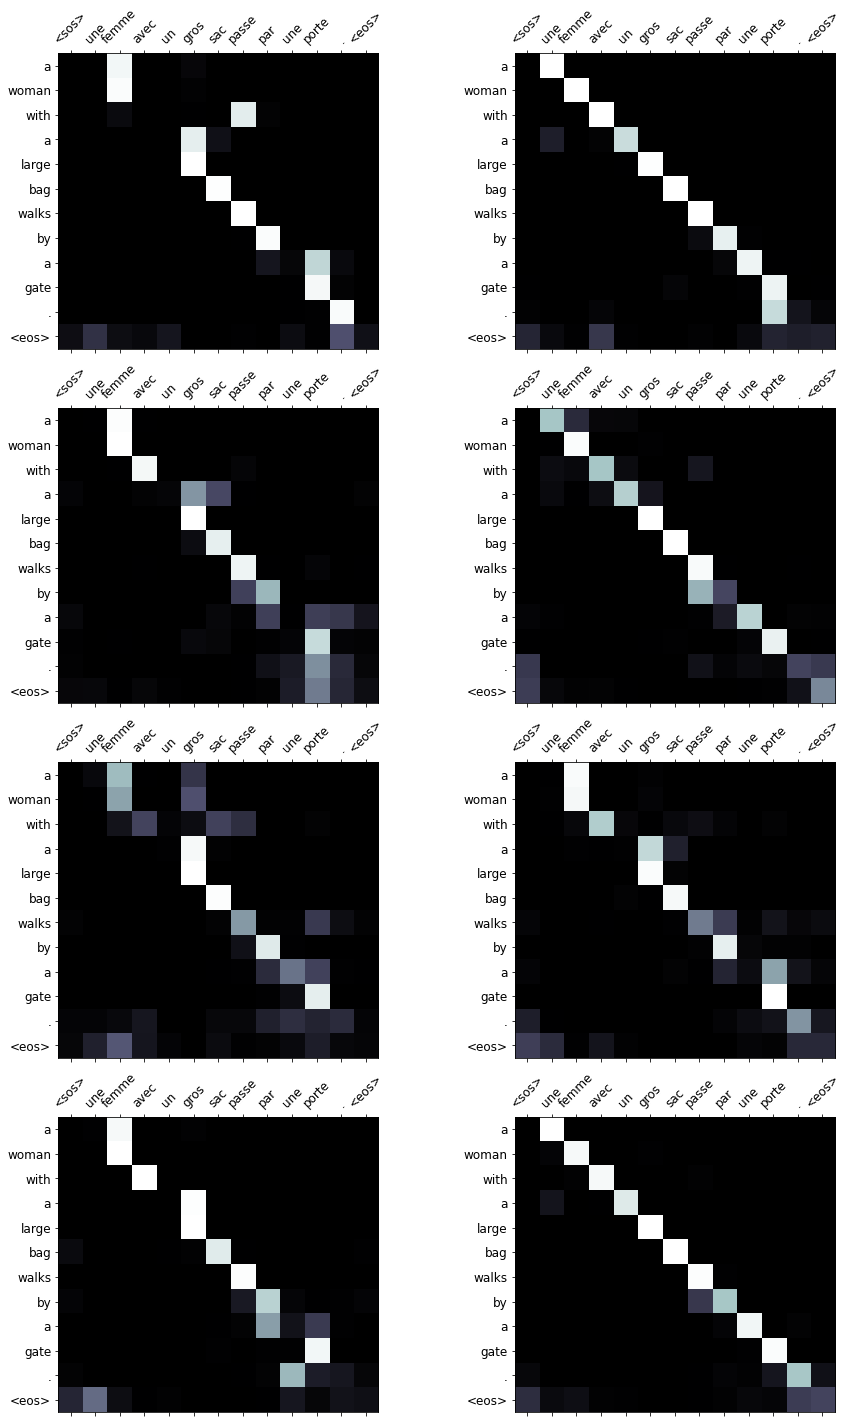

In [44]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [45]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['un', 'chien', 'brun', 'court', 'après', 'le', 'chien', 'noir', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [46]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'chases', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


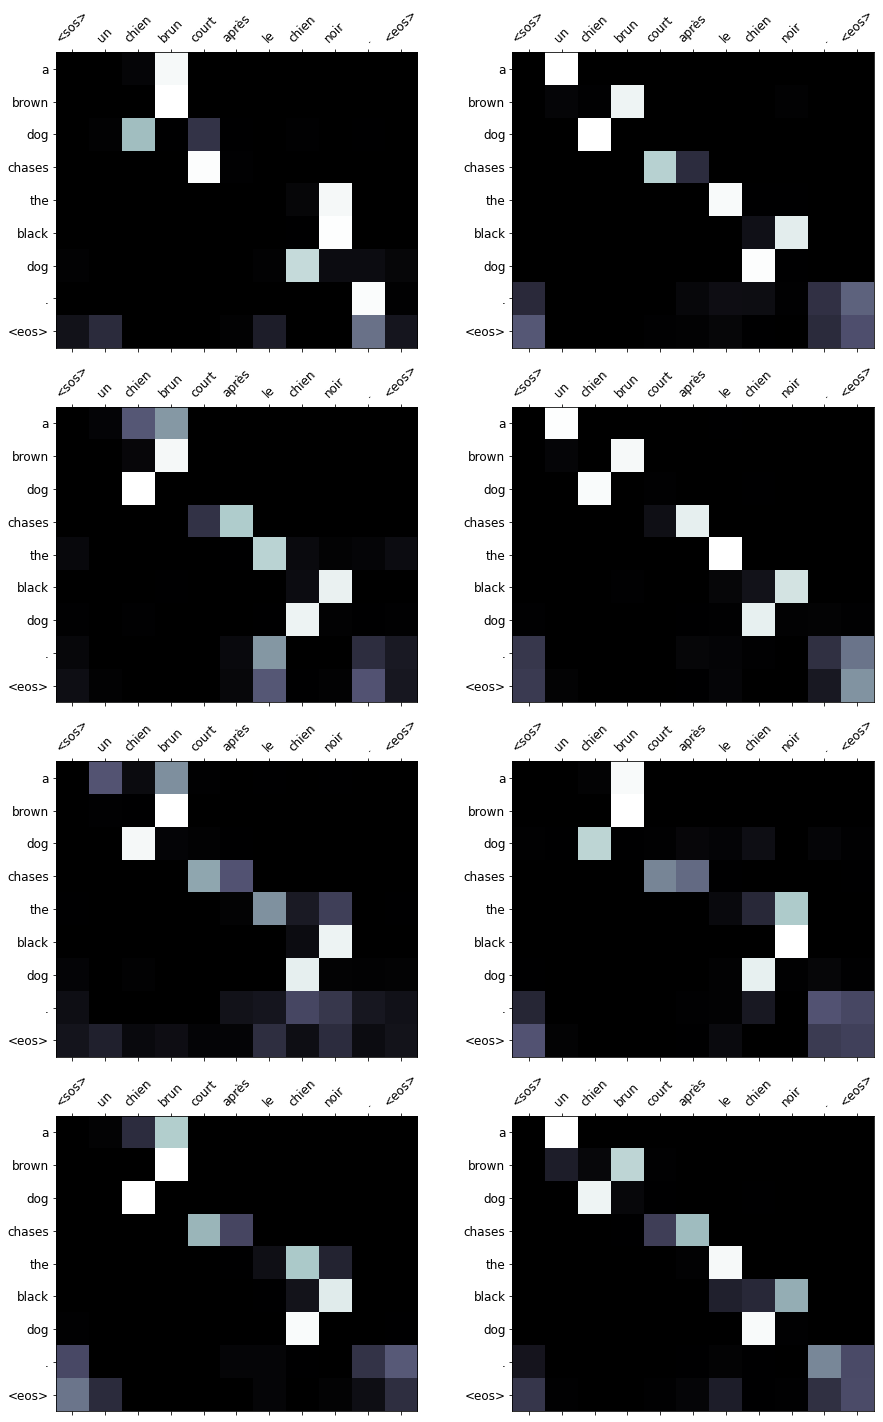

In [47]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [48]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['une', 'mère', 'et', 'son', 'jeune', 'fils', 'profitant', "d'", 'une', 'belle', 'journée', 'dehors', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [49]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


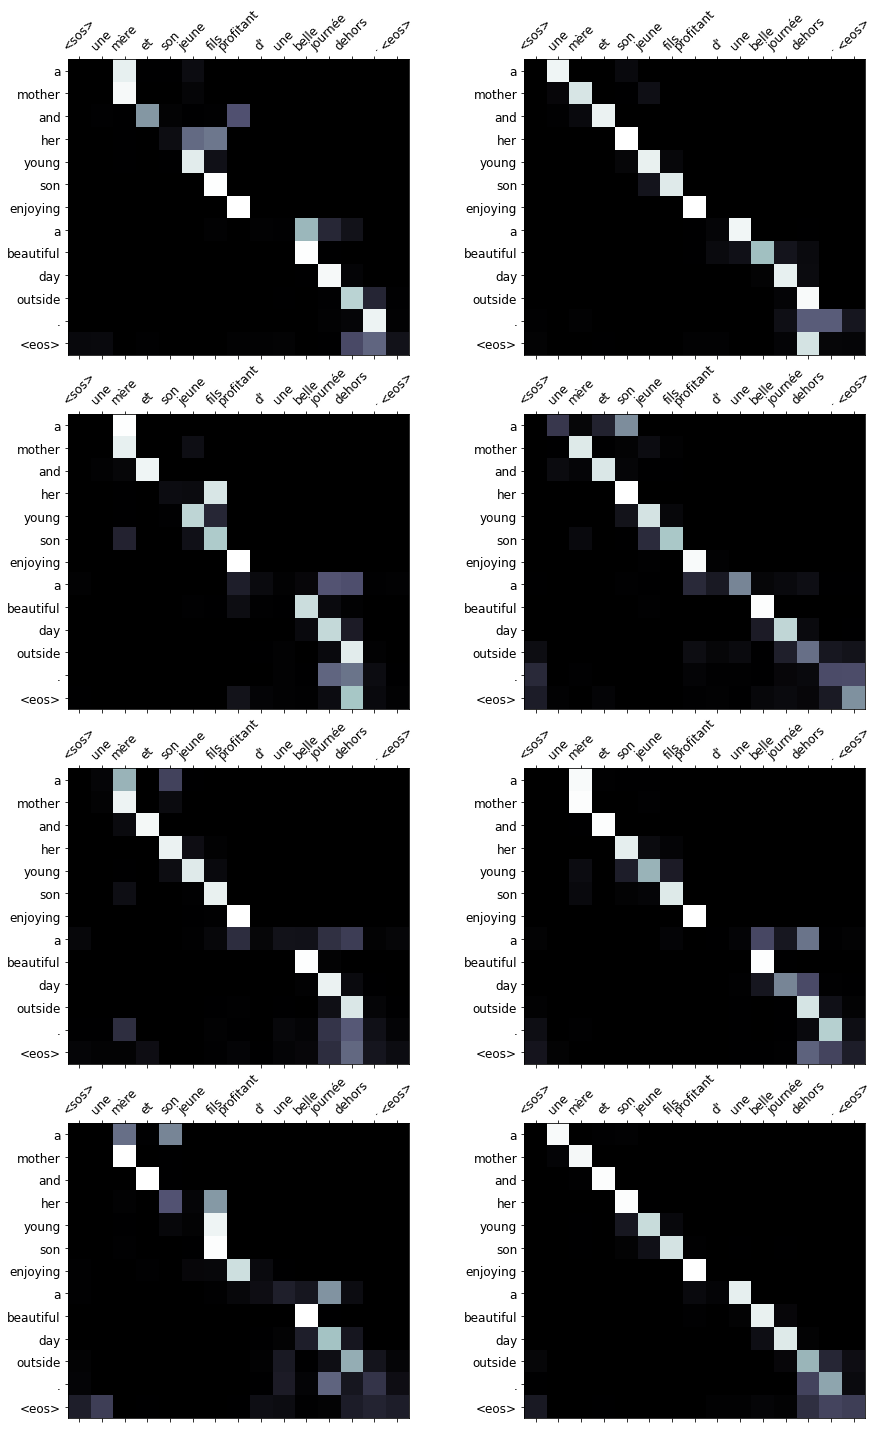

In [50]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [51]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [52]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 47.79


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [53]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [54]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)